# Modeling and Simulation in Python

Chapter 3: Explain

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [ ]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

Pandas is a module that provides tools for reading and processing data.  The `read_html` reads a web page from a file or the Internet and creates one DataFrame for each table on the page.

In [ ]:
from pandas import read_html

The data directory contains a downloaded copy of https://en.wikipedia.org/wiki/World_population_estimates

In [ ]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

`tables` is a sequence of DataFrame objects.  We can select the DataFrame we want using the bracket operator.  The tables are numbered from 0, so `table2` is actually the third table on the page.

`head` selects the header and the first five rows.

In [ ]:
table2 = tables[2]
table2.head()

`tail` selects the last five rows.

In [ ]:
table2.tail()

Long column names are awkard to work with, but we can replace them with abbreviated names.

In [ ]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Here's what the DataFrame looks like now.  

Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

In [ ]:
table2

We can use dot notatio to select a column from a DataFrame.  The result is a Series.

In [ ]:
census = table2.census
census

A Series object has two parts, `values` and `index`.

The `values` part is an array.

In [ ]:
census.values

The `index` part is yet another kind of object, an `Int64Index`.

In [ ]:
census.index

If you ever wonder what kind of object a variable refers to, you can use the `type` function.

The result indicates what type the object is, and the module where that type is defined.

DataFrame, Series, and Int64Index are defined by Pandas.

array is defined by NumPy.

In [ ]:
type(table2)

In [ ]:
type(census)

In [ ]:
type(census.index)

In [ ]:
type(census.values)

This function plots the estimates generated by the US Censis and UN DESA, and labels the axes.

`1e9` is scientific notation for $1 \cdot 10^9$ or 1 billion.

In [ ]:
def plot_estimates(table):
    """Plot world population estimates.
    
    table: DataFrame with columns 'un' and 'census'
    """
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)')

Now we can plot the estimates.

In [ ]:
newfig()
plot_estimates(table2)
savefig('chap03-fig01.pdf')

From here on, we will work in units of billions.

In [ ]:
un = table2.un / 1e9

In [ ]:
census = table2.census / 1e9

This expression computes the elementwise differences between the series, then divides through by the UN value to produce relative errors, then finds the largest element.

So the largest relative error between the estimates is about 1.3%.

In [ ]:
max(abs(census - un) / un) * 100

**Exercise:** Break down that expression into smaller steps and display the intermediate results, to make sure you understand how it works.

Where in the series is the largest relative error between the two estimates, near the beginning or the end? It is further away for longer time in the beginning but a bigger difference in the end

When I computed relative errors, I used `un` as the denominator.  But that was an arbitraty choice.  What happens if we use `census` instead?  How much difference does it make. .005

In [ ]:
abs(census - un)

In [ ]:
abs(census - un) / un

In [ ]:
abs(census - un) / un

In [ ]:
(abs(census - un) / un) * 100

### Constant growth

We can select an element from a series using bracket notation and one of the elements from the index.  Here's the first element:

In [ ]:
census[1950]

And the last element.

In [ ]:
census[2015]

But we can get the first and last years from the index itself:

In [ ]:
first_year = census.index[0]
last_year = census.index[-1]
first_year, last_year

And use them to look up the first and last elements.

Then we can compute the average annual growth in billions of people per year.

In [ ]:
total_growth = census[last_year] - census[first_year]
elapsed_time = last_year - first_year
annual_growth = total_growth / elapsed_time
annual_growth

Now let's create a `TimeSeries` to contain values generated by a linear growth model.

In [ ]:
results = TimeSeries()

Initially the Series is empty, but we can initialize it so the starting value, in 1950, is the 1950 population estimated by the US Census.

In [ ]:
results[1950] = census[1950]
results

After that, the population in the model grows by a constant amount each year.

In [ ]:
for t in linrange(1950, 2015):
    results[t+1] = results[t] + annual_growth

Here's what the results looks like, compared to the actual data.

In [ ]:
newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.pdf')

The model fits the data pretty well after 1990, but not so well before.

**Exercise:**  Try fitting the model using data from 1965 to the present, and see if that does a better job.

Hint: Copy the code from above and make a few changes.

Make sure your model starts in 1950, even though the estimated annual growth is based on later data.  You might have to shift the first value in the series up or down to match the data.

In [ ]:

results = TimeSeries()

for t in linrange(1950, 1965):
    results[t] = census[t]
    
for t in linrange(1965, 2015):
    results[t+1] = results[t] + annual_growth


newfig()
plot_estimates(table2)
plot(results, '--', color='gray', label='model')
decorate(xlabel='Year', ylabel='World population (billion)')
savefig('chap03-fig02.1.pdf')

### Now with system objects

We can rewrite the code from the previous section using system objects.

In [ ]:
t0 = census.index[0]
t_end = census.index[-1]
total_growth = census[t_end] - census[t0]
elapsed_time = t_end - t0
annual_growth = total_growth / elapsed_time

Here's the system object.

In [ ]:
system = System(t0=t0, 
                t_end=t_end,
                p0=census[t
                annual_growth=annual_growth)

And we can encapsulate the code tha runs the model in a function that stores the resulting Series as a new system variable.

In [ ]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    system.results = results

We can also encapsulate the code that plots the results.

In [ ]:
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot_estimates(table2)
    plot(system.results, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

In [ ]:
run_simulation1(system)
plot_results(system, title='Constant growth model')

`plot_results` uses `decorate`, which takes parameters that specify the title of the figure, labels for the $x$ and $y$ axis, and limits for the axes.  To read the documentation of `decorate`, run the cells below.

In [ ]:
help(decorate)

In [ ]:
plt.getp(plt.gca())

**Exercise:** The constant growth model doesn't make a lot of sense, because it seems like the number of deaths and births should depend on the size of the population.  As a small improvement, let's write a version of `run_simulation1` where the number of deaths is proportional to the size of the population, but the number of births is constant.  This model doesn't make a lot of sense, either, but it's a good exercise.

Write a function called `run_simulation1b` that implements a model where the number of births is constant, but the number of deaths is proportional to the current size of the population.  Set the death rate to `0.01`, which means that 1% of the population dies each year; then choose the number of annual births to make the model fit the data as well as you can.

Hint: It probably won't fit very well.

In [ ]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    death = .01 * system.p0
    births = .02
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = results[t] + system.annual_growth - death + births
    system.results = results
    

In [ ]:
run_simulation1(system)
plot_results(system, title='Constant growth model')

## Proportional death, proportional birth

Now let's get to a more realistic model where the number of births and deaths is proportional to the current population.

In [ ]:
def run_simulation2(system):
    """Runs the constant growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: system object
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
    system.results = results

I kept the death rate at 1% and chose the birth rate to fit the data.

In [ ]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

In [ ]:
run_simulation2(system)
plot_results(system, title='Proportional model')
savefig('chap03-fig03.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

**Exercise:** In this implementation, we compute the number of deaths and births separately, but since they are both proportional to the current population, we can combine them.

Write a function called `run_simulation2b` that implements a model with a single parameter, `alpha`, that represents the net growth rate, which is the difference between the birth and death rates.  For example, if `alpha=0.01`, the population should grow by 1% per year.

Choose the value of `alpha` that fits the data best.

In [ ]:
def run_simulation2b(alpha):
     results = TimeSeries()
     results[system.t0] = system.p0
     for t in linrange(system.t0, system.t_end):
        net = alpha * results[t]
        results[t+1] = results[t] + net
     system.results = results

In [ ]:
run_simulation2b(0.017)
plot_results(system, title='Proportional model')
savefig('chap03-fig03.1.pdf')

### Factoring out the update function

The functions that run the model all look the same except the body of the loop.  So we can factor that part out into a function.

In [ ]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    print(t, pop)
    return pop + births - deaths

Now the name `update_func1` refers to a function object.

In [ ]:
update_func1

Which we can confirm by checking its type.

In [ ]:
type(update_func1)

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [ ]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results

Here's how we use it.

In [ ]:
run_simulation(system, update_func1)

Remember not to put parentheses after `update_func1`.  What happens if you try?

In [ ]:
plot_results(system, title='Proportional model, factored')

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [ ]:
def update_func1b(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
   
    
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

In [ ]:
system.alpha = system.birth_rate - system.death_rate

run_simulation(system, update_func1b)
plot_results(system, title='Proportional model, combined birth and death')

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, might be changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write a function called `update_func1c` that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contains two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should compute and return the simulated population one year later.

Note: Don't forget the `return` statement.

In [ ]:
def update_func1c(pop, t, system):
    if t<1980:
        netgrowth = (system.alpha1  * pop)
    else:
        netgrowth= (system.alpha2  * pop)
    
     
    return pop +netgrowth

In [ ]:
system.alpha1=0.015
system.alpha2=0.016

run_simulation(system,update_func1c)
plot_results(system,title='Dynamic Alpha Model')

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [ ]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

And here are the results.  Can you find values for the parameters that make the model fit better?

In [ ]:
system.alpha = 0.025
system.beta = -0.0018

run_simulation(system, update_func2)
plot_results(system, title='Quadratic model')
savefig('chap03-fig04.pdf')

To understand the quadratic model better, let's plot net growth as a function of population.

In [ ]:
pop_array = linspace(0.001, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2

Here's what it looks like.  Remember that the x axis is population now, not time.

The function `sns.set` sets the style for the plots.  I added a grid to this one to make it easier to read.

In [ ]:
newfig()
sns.set(style='whitegrid', font_scale=1.5)
plot(pop_array, net_growth_array, '-')
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)',
         legend=False)
savefig('chap03-fig05.pdf')

Using `sns.set` to reset the plot style.

In [ ]:
sns.set(style='white', font_scale=1.5)

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [ ]:
-system.alpha / system.beta

This is the equilibrium the population tends toward.

**Exercise:** In the book, I presented a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func2` that implements this version of the model.  Test it by computing system variables `r` and `K` equivalent to `alpha` and `beta`, and confirm that you get the same results. 

In [ ]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    r=system.alpha
    k=-system.alpha/system.beta
    print(r,k)
    
    net_growth = r * pop * (1 - pop / k)
    return pop + net_growth

In [ ]:
system.alpha = 0.025
system.beta = -0.0018

run_simulation(system, update_func2)
plot_results(system, title='Quadratic model')
savefig('chap03-fig04.1.pdf')

**Exercise:** On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations.  The following cells process this table and plot some of the results.

Select `table1`, which is the second table on the page.

In [ ]:
table1 = tables[1]
table1.head()

Not all agencies and researchers provided estimates for the same dates.  Again `NaN` is the special value that indicates missing data.

In [ ]:
table1.tail()

Some of the estimates are in a form we can't read as numbers.  We could clean them up by hand, but for simplicity I'll replace any value that has an `M` in it with `NaN`.

In [ ]:
table1

In [ ]:
table1.replace('M', np.nan, regex=True, inplace=True)

Again, we'll replace the long column names with more convenient abbreviations.

In [ ]:
table1.columns = ['prb', 'un', 'maddison', 'hyde', 'tanton', 
                  'biraben', 'mj', 'thomlinson', 'durand', 'clark']

This function plots selected estimates.

In [367]:
def plot_prehistory(table):
    """Plots population estimates.
    
    table: DataFrame
    """
    plot(table.prb, 'ro', label='PRB')
    plot(table.un, 'co', label='UN')
    plot(table.hyde, 'yo', label='HYDE')
    plot(table.tanton, 'go', label='Tanton')
    plot(table.biraben, 'bo', label='Biraben')
    plot(table.mj, 'mo', label='McEvedy & Jones')

Here are the results.  Notice that we are working in millions now, not billions.

115.


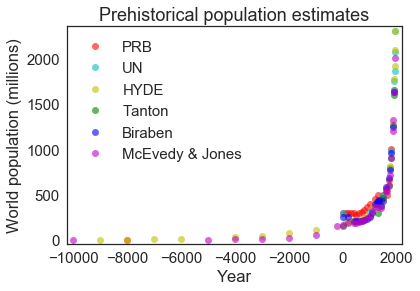

In [368]:
newfig()
plot_prehistory(table1)
decorate(xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')


We can use `xlim` to zoom in on everything after Year 0.

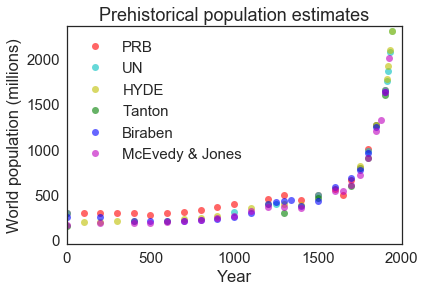

In [369]:
newfig()
plot_prehistory(table1)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')

See if you can find a model that fits these data well from Year -1000 to 1940, or from Year 0 to 1940.

How well does your best model predict actual population growth from 1950 to the present?

In [ ]:
"""def update_func3(pop, system):

    r=system.alpha
    k=-system.alpha/system.beta
    
    net_growth = r * pop * (1 - pop / k)
    return pop + net_growth

system=System(t0=-1000,
                t_end=1940,
                p0=table1.hyde[-1000], alpha=0.02, beta=-0.0018)"""

In [ ]:
#def run_simulation(system, update_func):
"""Simulate the system using any update function.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results



run_simulation(system, update_func3)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population Model')"""


In [422]:
model = TimeSeries()
r=1.00065
k=-.0018
model[-1000] = 75
for t in linrange(-1000, 1940):
    #model[t+1] = model[t] * r *(1 - model[t]/k)   runtime error
    model[t+1] = model[t] * r 
    #model[t+1]=model[t]**1.00014                ok but not fantastic
    


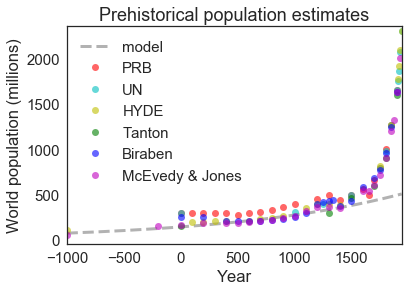

In [423]:
newfig()
plot(model, '--', color='gray', label='model')
plot_prehistory(table1)
decorate(xlim=[-1000, 1940], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')


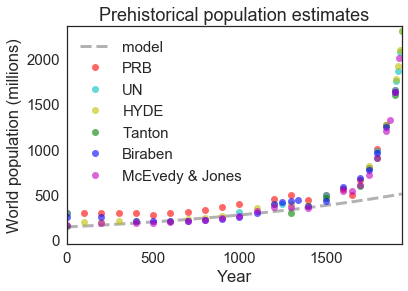

In [424]:
newfig()
plot(model, '--', color='gray', label='model')
plot_prehistory(table1)
decorate(xlim=[0, 1940], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistorical population estimates')
